In [1]:
import sys
sys.path.append('../functions')

# Import necessary libraries
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import time
from sklearn.metrics import r2_score, mean_absolute_error

# Import custom modules
from data_processing import load_and_process_data
from models import BayesianNN, predict_with_uncertainty, HamiltonianMonteCarlo, nll_loss
from metrics import calculate_metrics, calculate_observed_confidence
from post_processing import create_errorbar_plot, plot_abs_error_vs_std, plot_std_histogram, plot_calibration_curve

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
HYPERPARAMETERS = {
    'batch_size': 32,
    'hidden_layers': [201, 644, 873],
    'epochs': 1000,
    'learning_rate': 0.00008,
    'weight_init_std': 0.033,
    'log_std_init_mean': -1.410,
    'log_std_init_std': 0.025,
    'log_std_clamp': (-7.26, 3.74),
    'grad_clip_norm': 0.69,
    'n_samples_uncertainty': 250,
    # HMC specific parameters
    'hmc_step_size': 0.00004,  # Much smaller step size for numerical stability
    'hmc_num_steps': 50,
    'hmc_num_samples': 110,
    'hmc_burn_in': 70,
    'prior_std': 13,
    'num_zero_threshold': 3600
}

# Load and process data
file_path = "../data/other_property/Tm.csv"  # Update with your file path
X_count, Y = load_and_process_data(file_path, HYPERPARAMETERS['num_zero_threshold'])

# Split data into training, validation, and test sets
xtrain, xtemp, ytrain, ytemp = train_test_split(X_count, Y, test_size=0.2, random_state=11)
xval, xtest, yval, ytest = train_test_split(xtemp, ytemp, test_size=0.5, random_state=42)

# Convert data to PyTorch tensors and move to device
xtrain_tensor = torch.tensor(xtrain.values).float().to(device)
ytrain_tensor = torch.tensor(ytrain).float().to(device)
xval_tensor = torch.tensor(xval.values).float().to(device)
yval_tensor = torch.tensor(yval).float().to(device)
xtest_tensor = torch.tensor(xtest.values).float().to(device)
ytest_tensor = torch.tensor(ytest).float().to(device)

# Create DataLoader for training data
train_data = TensorDataset(xtrain_tensor, ytrain_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=HYPERPARAMETERS['batch_size'], shuffle=True)

# Initialize and train the BNN model
model = BayesianNN(
    n_features=xtrain.shape[1],
    HYPERPARAMETERS=HYPERPARAMETERS
)

In [3]:

# Train the model
start_time = time.time()

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=HYPERPARAMETERS['learning_rate'])
dataset = TensorDataset(xtrain_tensor, ytrain_tensor)
loader = DataLoader(dataset, batch_size=HYPERPARAMETERS['batch_size'], shuffle=True)
# Pre-train with standard optimization
best_loss = float('inf')
early_stop_counter = 0
for epoch in range(HYPERPARAMETERS['epochs']):
    model.train()
    epoch_loss = 0.0
    for xb, yb in loader:
        optimizer.zero_grad()
        mean, log_std = model(xb)
        loss = nll_loss(mean, log_std, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), HYPERPARAMETERS['grad_clip_norm'])
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss/len(loader)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{HYPERPARAMETERS['epochs']} - Loss: {avg_loss:.4f}")
        
    if avg_loss < best_loss:
        best_loss = avg_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        
    if early_stop_counter >= 50:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Evaluate pre-trained model
model.eval()
with torch.no_grad():
    pre_mean, pre_log_std = model(xtest_tensor)
    pre_mean = pre_mean.cpu().numpy().flatten()
    pre_r2 = r2_score(ytest, pre_mean)
    pre_mae = mean_absolute_error(ytest, pre_mean)
    print(f"Pre-trained model - MAE: {pre_mae:.4f}, R^2: {pre_r2:.4f}")

# HMC sampling
print("Starting HMC sampling...")

model.eval()

print(f"Model device: {next(model.parameters()).device}")
print(f"Input tensors - xtrain: {xtrain_tensor.device}, ytrain: {ytrain_tensor.device}")

hmc = HamiltonianMonteCarlo(
    model=model, 
    X=xtrain_tensor, 
    y=ytrain_tensor,
    step_size=HYPERPARAMETERS['hmc_step_size'],
    num_steps=HYPERPARAMETERS['hmc_num_steps'],
    prior_std=HYPERPARAMETERS['prior_std']
)
print(f"HMC device: {hmc.device}")

# Initialize with pre-trained weights and ensure it's on the correct device
current_params = model.get_params().clone().detach().to(device)
print(f"Initial params device: {current_params.device}")

# Burn-in phase
print(f"HMC burn-in phase ({HYPERPARAMETERS['hmc_burn_in']} iterations)...")
acceptance_rate = 0
step_size = HYPERPARAMETERS['hmc_step_size']

# Initialize params_samples as empty - this is needed to avoid reference issues
params_samples = None

for i in range(HYPERPARAMETERS['hmc_burn_in']):
    print(f"Burn-in iteration {i+1}")
    
    if i > 0 and i % 10 == 0:
        current_acceptance = acceptance_rate / (i+1)
        if current_acceptance < 0.6:
            step_size *= 0.8
        elif current_acceptance > 0.8:
            step_size *= 1.2
        
        hmc.step_size = step_size
        print(f"Adapted step size to {step_size:.8f}, current acceptance rate: {current_acceptance:.4f}")
    
    # Ensure params are on device
    current_params = current_params.to(device)
    print(f"  current_params device before HMC: {current_params.device}")
    
    # Try to get more debug info
    try:
        current_params, accepted = hmc.sample(current_params)
    except RuntimeError as e:
        print(f"Error in HMC sampling: {e}")
        print(f"current_params device: {current_params.device}")
        # Print device of model parameters
        for name, param in model.named_parameters():
            print(f"{name} device: {param.device}")
        raise
        
    acceptance_rate += accepted
    
    if (i + 1) % 10 == 0:
        print(f"Burn-in iteration {i+1}/{HYPERPARAMETERS['hmc_burn_in']} - Acceptance rate: {acceptance_rate/(i+1):.4f}")

print(f"HMC burn-in acceptance rate: {acceptance_rate/HYPERPARAMETERS['hmc_burn_in']:.4f}")

# Sampling phase
print(f"HMC sampling phase ({HYPERPARAMETERS['hmc_num_samples']} samples)...")
params_samples = []  # Reset
acceptance_rate = 0

for i in range(HYPERPARAMETERS['hmc_num_samples']):
    # Ensure params are on device
    current_params = current_params.to(device)
    current_params, accepted = hmc.sample(current_params)
    acceptance_rate += accepted
    
    if accepted:
        params_samples.append(current_params.clone().detach().to(device))
    
    if (i + 1) % 10 == 0:
        print(f"Sampling iteration {i+1}/{HYPERPARAMETERS['hmc_num_samples']} - Acceptance rate: {acceptance_rate/(i+1):.4f}")
        
print(f"HMC sampling acceptance rate: {acceptance_rate/HYPERPARAMETERS['hmc_num_samples']:.4f}")
print(f"Number of unique parameter samples: {len(params_samples)}")

end_time = time.time()

# Print elapsed time
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Epoch 100/1000 - Loss: 4.7973
Epoch 200/1000 - Loss: 3.5614
Epoch 300/1000 - Loss: 3.2821
Epoch 400/1000 - Loss: 3.1135
Epoch 500/1000 - Loss: 3.0180
Early stopping at epoch 569
Pre-trained model - MAE: 40.1568, R^2: 0.7218
Starting HMC sampling...
Model device: cuda:0
Input tensors - xtrain: cuda:0, ytrain: cuda:0
Model device in HMC init: cuda:0
Setting HMC device to: cuda:0
HamiltonianMonteCarlo initialized with device: cuda:0
HMC device: cuda:0
Initial params device: cuda:0
HMC burn-in phase (70 iterations)...
Burn-in iteration 1
  current_params device before HMC: cuda:0
Burn-in iteration 2
  current_params device before HMC: cuda:0
Burn-in iteration 3
  current_params device before HMC: cuda:0
Burn-in iteration 4
  current_params device before HMC: cuda:0
Burn-in iteration 5
  current_params device before HMC: cuda:0
Burn-in iteration 6
  current_params device before HMC: cuda:0
Burn-in iteration 7
  current_params device before HMC: cuda:0
Burn-in iteration 8
  current_params de

In [4]:
# Make predictions with uncertainty on training and test data
mean_train, std_train = predict_with_uncertainty(model, xtrain_tensor.to(device), params_samples, HYPERPARAMETERS['n_samples_uncertainty'])
mean_test, std_test = predict_with_uncertainty(model, xtest_tensor.to(device), params_samples, HYPERPARAMETERS['n_samples_uncertainty'])

# Convert predictions to numpy for metric calculation
mean_train = mean_train.cpu().numpy()
std_train = std_train.cpu().numpy()
mean_test = mean_test.cpu().numpy()
std_test = std_test.cpu().numpy()

# Calibration curve
confidence_levels = np.arange(0, 1.05, 0.05)

# Calculate metrics
train_metrics = calculate_metrics(ytrain, mean_train, std_train, confidence_levels)
test_metrics = calculate_metrics(ytest, mean_test, std_test, confidence_levels)

# Create a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Test'],
    'MAE': [train_metrics['MAE'], test_metrics['MAE']],
    'RMSE': [train_metrics['RMSE'], test_metrics['RMSE']],
    'R2': [train_metrics['R2'], test_metrics['R2']],
    'Spearman': [train_metrics['Spearman'], test_metrics['Spearman']],
    'Calibration Area': [train_metrics['Calibration Area'], test_metrics['Calibration Area']]
})

# Print the DataFrame
print(metrics_df)

Using 103 HMC samples for prediction
Using 103 HMC samples for prediction
    Dataset        MAE       RMSE        R2  Spearman  Calibration Area
0  Training  16.726258  23.731539  0.952051  0.426961          0.186545
1      Test  43.514774  62.090159  0.713578  0.159666          0.333379


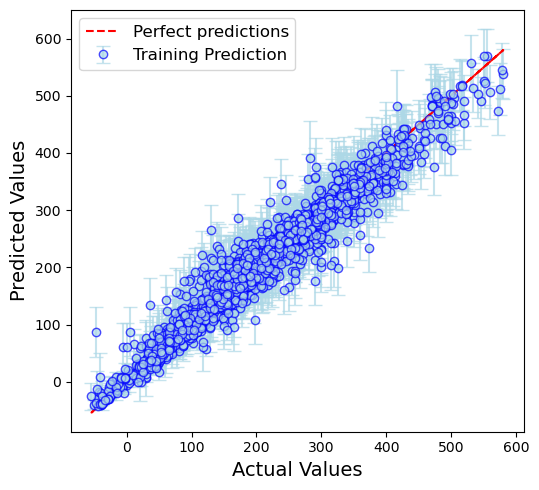

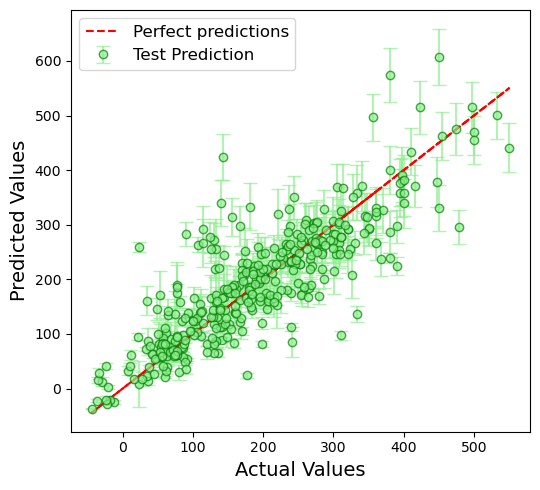

In [5]:
# Plot results
create_errorbar_plot(ytrain, mean_train, std_train, 'blue', 'Training')
create_errorbar_plot(ytest, mean_test, std_test, 'green', 'Test')

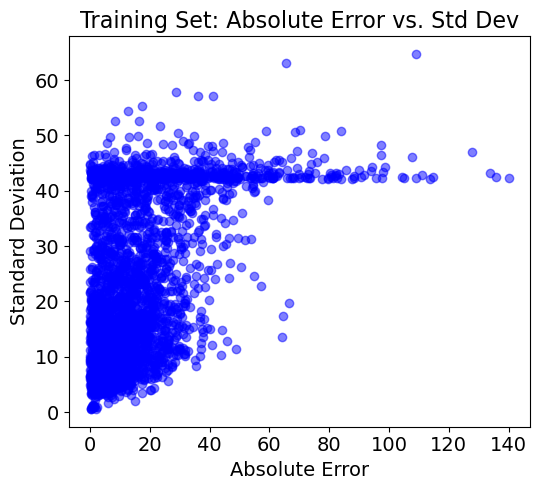

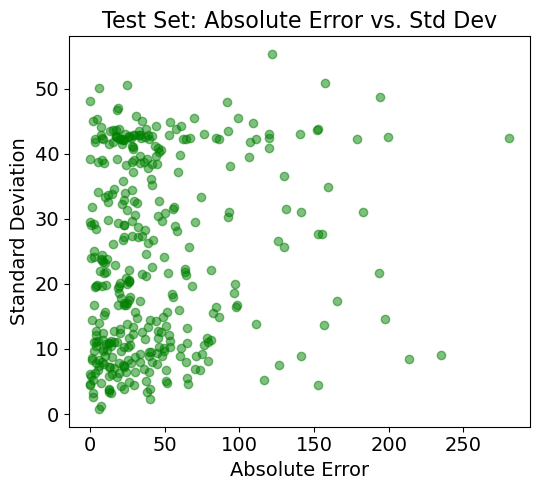

In [6]:
# Plot additional figures
abs_error_train = np.abs(ytrain - mean_train)
abs_error_test = np.abs(ytest - mean_test)

plot_abs_error_vs_std(abs_error_train, std_train, 'Training', 'blue')
plot_abs_error_vs_std(abs_error_test, std_test, 'Test', 'green')

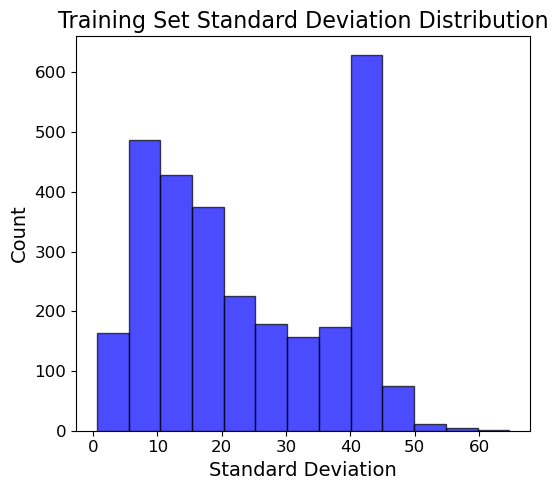

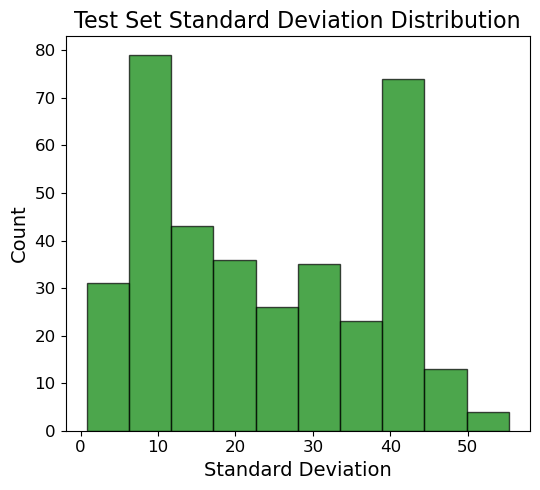

In [7]:
plot_std_histogram(std_train, 'Training', 'blue')
plot_std_histogram(std_test, 'Test', 'green')

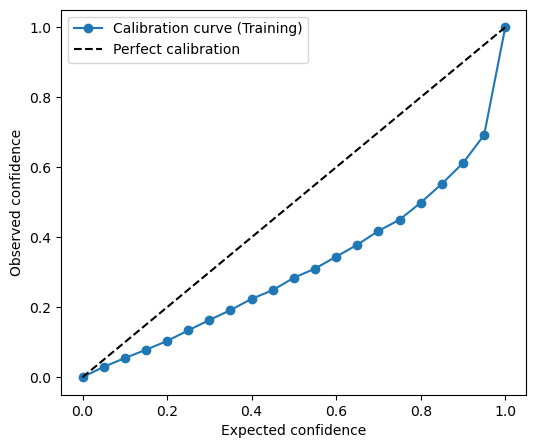

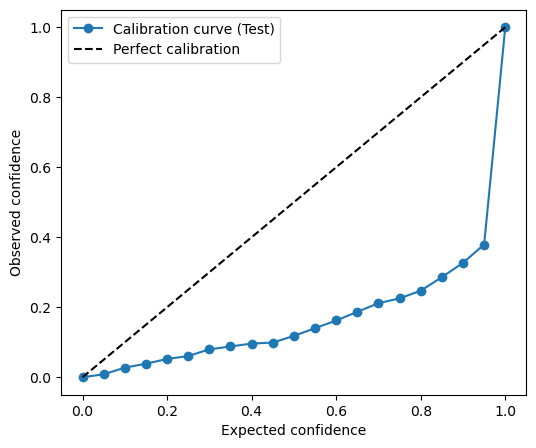

In [8]:
# Calculate observed confidence
observed_confidence_train = calculate_observed_confidence(ytrain, mean_train, std_train, confidence_levels)
observed_confidence_test = calculate_observed_confidence(ytest, mean_test, std_test, confidence_levels)

# Plot calibration curves
plot_calibration_curve(confidence_levels, observed_confidence_train, 'Training')
plot_calibration_curve(confidence_levels, observed_confidence_test, 'Test')